In [281]:
#Libraries
from math import floor, exp, sqrt, pi
import cmath
import numpy
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace
import matplotlib.pyplot as plt
from itertools import chain
import scipy
from scipy import special
import numpy as np 
import seaborn as sns


In [306]:
#Parameters

totalTime=6200;
dt=2;
nsteps=int(floor(totalTime/dt));
num_cicles=10;

    
N=512;
origin = pi

#temporal variable (largerT --> smaller firing rate)
tauE=  60  #6; 
tauI=  10 #10; 
tauf =7000
taud =80



#Conductances (larger G means larger firing rate). Diff cond. for connections
I0E=  1.3   ####1.9##0.2; (as it decreases --> less bumps)
I0I=  0.4    ##0.5; (as it increases --> less bumps)
U =0.4
#Realted with noise
sigE=  0.7 #1.5 #1 #0.5 ;
sigI=  0.04 #1.6 #2 #1.3 ;



GEE=  0.016
GEI=  0.015
GIE=  0.012  
GII=  0.007  
#Realted with noise
# sigE=  1.5 #1.5 #1 #0.5 ;
# sigI=  1.6 #1.6 #2 #1.3 ;



#Stimulus (when on and off, separation between them and strenght)
targ_onset = 200;
targ_offset = 450;
dist_onset = 93600 #500 #900 #3000 #3000 
dist_offset = 93850 #2800 #1400 # 3500 #3500 

n_stims=2; #2
stim_sep = pi/16 ###13 --> 2   (13 attract, 9 solo 1, 5 repulsion, 2 nada)
#stim_sep=0



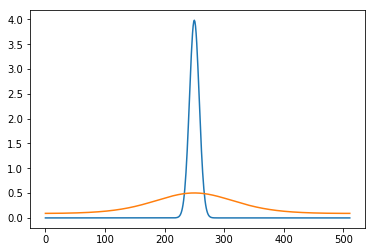

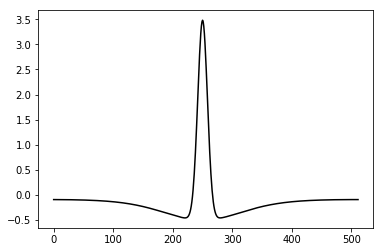

In [307]:
#Connectivities

kappa_E=  100  # 100  1/k in vaon misses is std    ( https://en.wikipedia.org/wiki/Von_Mises_distribution) 
kappa_I=1.5 ###2.9 

v_E=zeros((N));
v_I=zeros((N));
WE=zeros((N,N));
WI=zeros((N,N));


theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)] 

for i in range(0, N):
    v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
    v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) + 0.07 for f in range(0, len(theta))] #0.18
    ###    
    vE_NEW=roll(v_E_new,i)
    vI_NEW=roll(v_I_new,i) #to roll
    ###    
    WE[:,i]=vE_NEW
    WI[:,i]=vI_NEW

    
    
    
plt.plot(WE[250, :])
plt.plot(WI[250, :])
plt.show(block=False)

topography_pattern  =  WE[250, :] + -1*(WI[250, :])
plt.plot(topography_pattern, 'k')
plt.show(block=False)



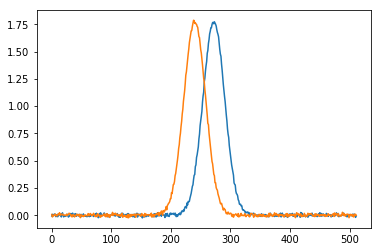

In [308]:
# stims

kappa_stim= 20

target=zeros((N))
distractor=zeros((N))

for i in range(0, N):
    target[i]=e**(kappa_stim*cos(theta[i] + origin - stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 
    distractor[i]=e**(kappa_stim*cos(theta[i] + origin + stim_sep)) / (2*pi*scipy.special.i0(kappa_stim)) 


target = target+ np.random.normal(0, 0.01, N)
target=reshape(target, (N,1)) 


distractor = distractor+ np.random.normal(0, 0.01, N)
distractor=reshape(distractor, (N,1)) 

    
######################

targon = floor(targ_onset/dt);
targoff = floor(targ_offset/dt);

diston = floor(dist_onset/dt);
distoff = floor(dist_offset/dt);

plt.plot(target)
plt.plot(distractor)
plt.show(block=False)

In [309]:
#Simulation

rE=zeros((N,1));
rI=zeros((N,1)); 
u = np.ones((N,1))*U
x = np.ones((N,1))

#generation of the noise and the connectivity between inhib and exit
RE=zeros((N,nsteps));
RI=zeros((N,nsteps));
p_u=np.ones((N,nsteps));
p_x=np.ones((N,nsteps));

f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)


### diferential equations
for i in range(0, nsteps):
    noiseE = sigE*random.randn(N,1);
    noiseI = sigI*random.randn(N,1);
    
    #differential equations for connectivity
    IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) + I0E*ones((N,1)); 
    II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));
    
    if i>targon and i<targoff:
        IE=IE+target;
        II=II+target;
    
    if i>diston and i<distoff:
        IE=IE+distractor;
        II=II+distractor;
    
    
    #rates of exit and inhib   
    rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
    rI = rI + (f(II) - rI + noiseI)*dt/tauI;
    #re_norm = (rE-min(rE))/(   max(rE) - min(rE));    
    ### formulas:
    #### paper mongillo 2008
    #### http://www.scholarpedia.org/article/Short-term_synaptic_plasticity
    ##
    u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
    x = x + ((1 - x)/taud - u*x*rE/1000)*dt;
    
    
    
    #
    #####facilitation = facilitation + ( - (facilitation-1) + k_Ca * rE ) *dt/tauCa 
    
    rEr=reshape(rE, N)
    rIr=reshape(rI, N)
    ur=reshape(u, N)
    xr=reshape(x, N)
    #drawnow
    RE[:,i] = rEr;
    RI[:,i] = rIr;
    p_u[:,i] = ur;
    p_x[:,i] = xr;
    






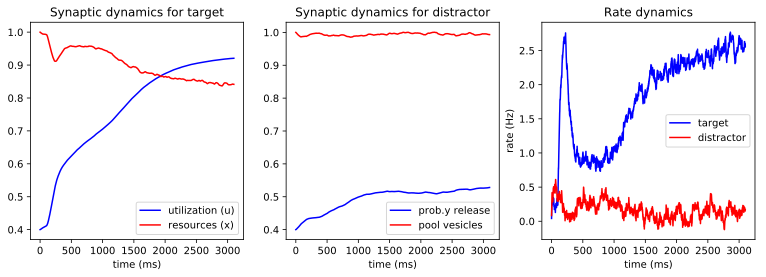

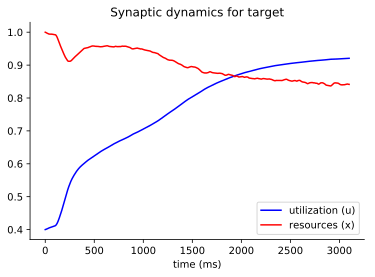

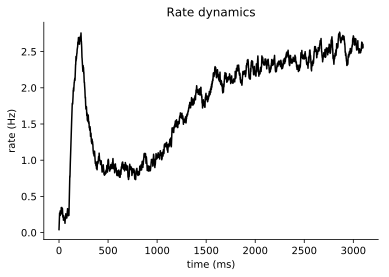

In [323]:
fig = plt.figure()
fig.tight_layout()
fig.set_size_inches(13, 4)
fig.add_subplot(131)
p_targ = int((N * np.degrees(origin + stim_sep))/360)
plt.title('Synaptic dynamics for target')
plt.plot(p_u[p_targ, :], 'b', label='utilization (u)')
plt.plot(p_x[p_targ, :], 'r', label='resources (x)')
plt.xlabel('time (ms)')
plt.legend()
fig.add_subplot(132)
p_dist= int((N * np.degrees(origin - stim_sep))/360)
plt.title('Synaptic dynamics for distractor')
plt.plot(p_u[p_dist, :], 'b', label='prob.y release')
plt.plot(p_x[p_dist, :], 'r', label='pool vesicles')
plt.xlabel('time (ms)')
plt.legend()
fig.add_subplot(133)
plt.title('Rate dynamics')
plt.plot(RE[p_targ, :], 'b', label='target')
plt.plot(RE[p_dist, :], 'r', label='distractor')
plt.xlabel('time (ms)')
plt.ylabel('rate (Hz)')
plt.legend()

%config InlineBackend.figure_format = 'svg'

plt.figure()
plt.title('Synaptic dynamics for target')
plt.plot(p_u[p_targ, :], 'b', label='utilization (u)')
plt.plot(p_x[p_targ, :], 'r', label='resources (x)')
plt.xlabel('time (ms)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()


plt.figure()
plt.title('Rate dynamics')
plt.plot(RE[p_targ, :], 'k')
plt.xlabel('time (ms)')
plt.ylabel('rate (Hz)')
plt.xlabel('time (ms)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)



In [ ]:
plt.figure()
plt.title('Synaptic dynamics for target')
plt.plot(p_u[p_targ, :], 'b', label='utilization (u)')
plt.plot(p_x[p_targ, :], 'r', label='resources (x)')
plt.xlabel('time (ms)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()

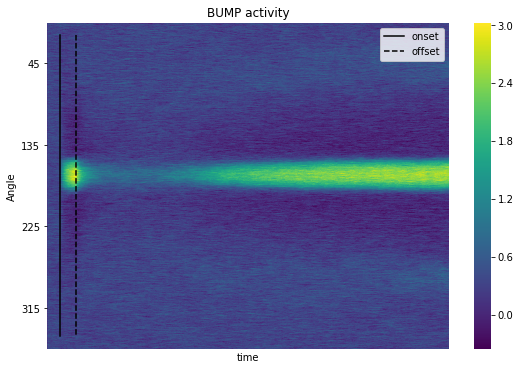

In [321]:
### Plot of activity
RE_sorted=flipud(RE)
plt.figure(figsize=(9,6))
sns.heatmap(RE_sorted, cmap='viridis')
plt.title('BUMP activity')
plt.ylabel('Angle')
plt.xlabel('time')
#plt.plot([targon, nsteps], [p_dist, p_dist], '--b',) ## flipped, so it is p_target 
plt.plot([diston, nsteps], [p_targ, p_targ], '--r',) ## flipped, so it is p_target 
plt.yticks([])
plt.xticks([])

plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])

plt.plot([targ_onset/2, targ_onset/2,], [0+20, N-20], 'k-', label='onset')
plt.plot([targ_offset/2, targ_offset/2,], [0+20, N-20], 'k--', label='offset')

plt.plot([dist_onset/2, dist_onset/2,], [0+20, N-20], 'k-')
plt.plot([dist_offset/2, dist_offset/2,], [0+20, N-20], 'k--')

plt.legend()
plt.show(block=False)

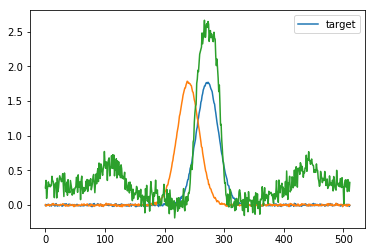

In [312]:
plt.plot(target, label='target')
plt.plot(distractor)
plt.plot(rE)
plt.legend()

In [313]:
circ_dist(decode_rE(target), decode_rE(distractor) )

22.520814528136583

In [314]:
#Decoding fucntions

In [315]:
def decode_rE(rE, a_ini=0, a_fin=360, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    Angles = np.linspace(a_ini, a_fin, N) 
    angles=np.radians(Angles)
    rE = np.reshape(rE, (1,N))
    R = numpy.sum(np.dot(rE,exp(1j*angles)))/numpy.sum(rE)
    
    angle_decoded = np.degrees(np.angle(R))
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded
    
    return angle_decoded
    #Mat.append(  [angle(R), abs(angle(R)) , degrees(abs(angle(R)))]  )
    #return round( np.degrees(abs(np.angle(R))), 2)


def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)




def Interference_effects(target, response, reference):
    #input list of target, list of responses and list of references
    #Error_interference; positive for attraction and negative for repulsion
    #######
    #Decimals to get
    decimals=2
    ####
    interferences=[]
    for i in range(0, len(target)):
        angle_err_abs=abs(target[i] - response[i])
        if circ_dist(np.array(response)[i], np.array(reference)[i])<=circ_dist(np.array(target)[i], np.array(reference)[i]):
            Err_interference=round( angle_err_abs, decimals) 
        else:
            Err_interference=round( -angle_err_abs, decimals)

        interferences.append(Err_interference)
    
    return interferences


In [316]:
interference = Interference_effects( [decode_rE_lim(target)], [decode_rE(rE)], [decode_rE(distractor)])[0]
print(interference)

-0.13
